In [ ]:
import sys
from pathlib import Path

if "__file__" in globals():
    ROOT = Path(__file__).resolve().parent.parent
else:
    ROOT = Path().resolve().parent.parent

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

In [ ]:
import lightning as L
import pandas as pd
import torch
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import TensorDataset

from anomalysuite.data.random_data import RandomDataGenerator
from anomalysuite.reconstructor.tranad import TranAD

BATCH_SIZE = 64
SEQUNECE_LENGTH = 50
NUMBER_OF_FEATURES = 3

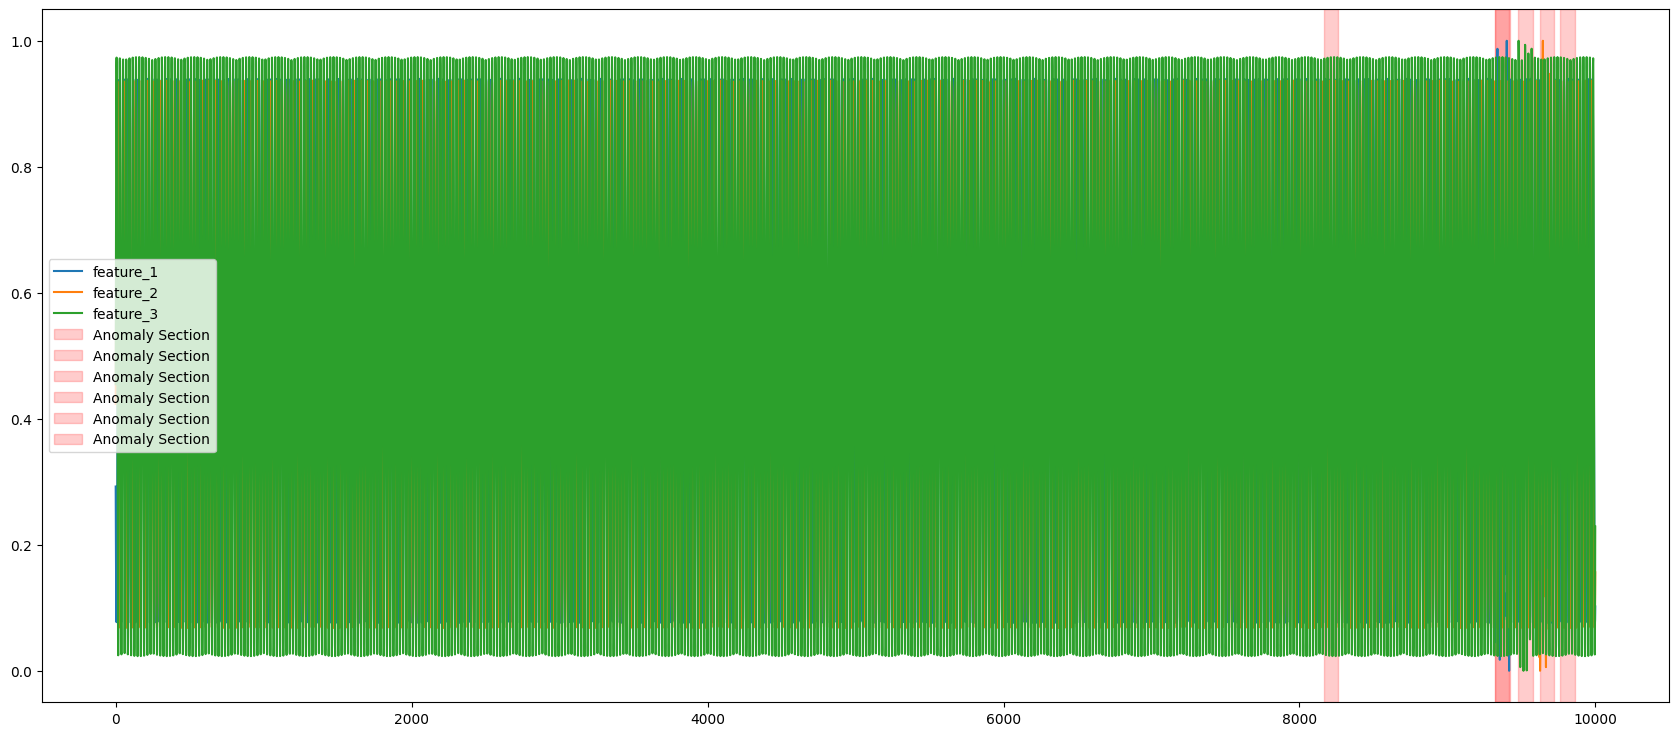

In [3]:
data_generator = RandomDataGenerator(length=10000, anomaly_length=100, features=NUMBER_OF_FEATURES, seed=42)
df = data_generator.get_data()
data_generator.plot()

In [4]:
length = len(df)
df_train = df.iloc[: int(length * 0.5)]
df_val = df.iloc[int(length * 0.5) : int(length * 0.7)]
df_pred = df.iloc[int(length * 0.7) :]


def df_to_dataloader(df: pd.DataFrame, batch_size: int) -> DataLoader:
    """Convert pandas DataFrame to torch DataLoader.

    pandas DataFrame data will be windowed(rolled) to use on TranAD model.
    for example) if df has 10000 rows and 3 columns: (10000,3)
    it will be shaped (9951, 3, 50) when the sequence length is 50.
    then dataloader will pass this data with the shape of (batch_size, 3, 50)

    Args:
        df: pandas DataFrame
        batch_size: batch size for DataLoader.

    Returns:
        torch DataLoader.

    """
    data_tensor = torch.FloatTensor(df.values)
    rolled_tensor = data_tensor.unfold(0, SEQUNECE_LENGTH, 1)
    rolled_tensor = rolled_tensor.permute(0, 2, 1)
    dataset = TensorDataset(rolled_tensor, rolled_tensor)
    return DataLoader(dataset, batch_size=batch_size, num_workers=10)


train_dataloader = df_to_dataloader(df_train, batch_size=BATCH_SIZE)
val_dataloader = df_to_dataloader(df_val, batch_size=BATCH_SIZE)
pred_dataloader = df_to_dataloader(df_pred, batch_size=BATCH_SIZE)

In [5]:
model = TranAD(
    sequence_length=SEQUNECE_LENGTH, number_of_features=NUMBER_OF_FEATURES, dim_feedforward=4096, num_layers=2
)

trainer = L.Trainer(callbacks=[EarlyStopping(monitor="val_loss", patience=5)], max_epochs=50)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

/root/projects/anomalysuite/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/root/projects/anomalysuite/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                             

Epoch 49: 100%|██████████| 78/78 [00:02<00:00, 35.46it/s, v_num=18, val_loss=0.0171]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 78/78 [00:02<00:00, 34.83it/s, v_num=18, val_loss=0.0171]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 47/47 [00:00<00:00, 132.01it/s]


<Axes: >

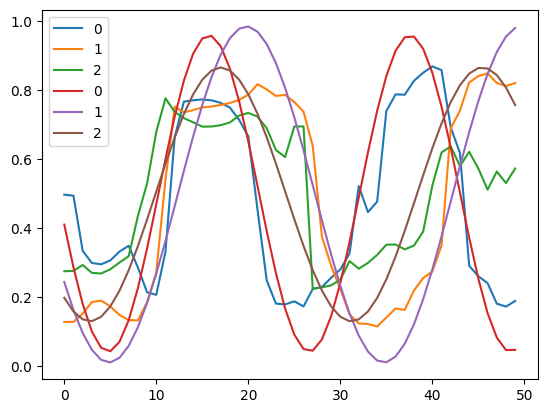

In [6]:
pred = trainer.predict(model, pred_dataloader)
pd.concat([pd.DataFrame(pred[0][0]), pd.DataFrame(list(pred_dataloader)[0][0][0])], axis=1).plot()

In [7]:
from anomalysuite.processor.torch_processor import predict_dataframe

df_hat = predict_dataframe(model=model, df_data=df_pred)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/projects/anomalysuite/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


<Axes: >

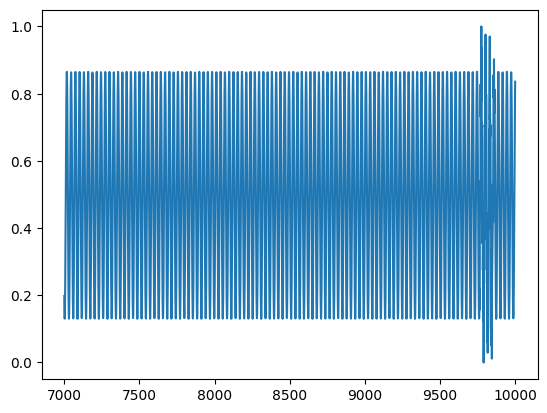

In [14]:
df_pred.iloc[:, -1].plot()

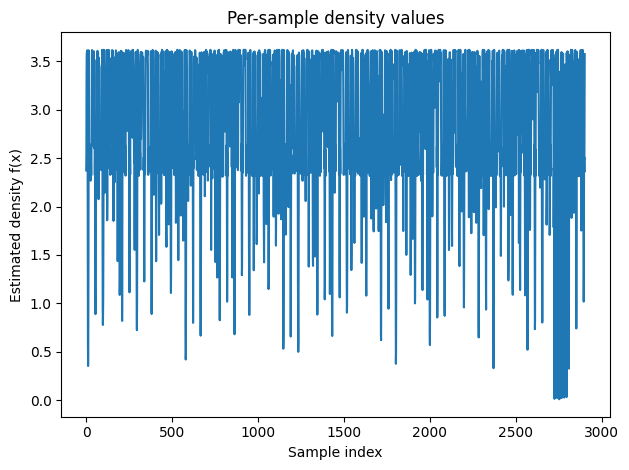

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

df_residuals = (df_pred - df_hat).dropna()
x = df_residuals.iloc[:, -1].to_numpy()
kde = gaussian_kde(x)
densities = kde(x)

plt.plot(np.arange(len(x)), densities)
plt.xlabel("Sample index")
plt.ylabel("Estimated density f(x)")
plt.title("Per-sample density values")
plt.tight_layout()
plt.show()